<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Digits-Data" data-toc-modified-id="Digits-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Digits Data</a></span><ul class="toc-item"><li><span><a href="#Show-data-sampe" data-toc-modified-id="Show-data-sampe-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Show data sampe</a></span></li></ul></li><li><span><a href="#Pytorch-Linear-Regression" data-toc-modified-id="Pytorch-Linear-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pytorch Linear Regression</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-class" data-toc-modified-id="Logistic-Regression-class-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression class</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Train-on-digits-data-set" data-toc-modified-id="Train-on-digits-data-set-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train on digits data set</a></span></li><li><span><a href="#Evaluate-digits" data-toc-modified-id="Evaluate-digits-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Evaluate digits</a></span></li><li><span><a href="#Misclassified-examples" data-toc-modified-id="Misclassified-examples-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Misclassified examples</a></span></li></ul></li><li><span><a href="#Logistic-Regression-with-sklearn" data-toc-modified-id="Logistic-Regression-with-sklearn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic Regression with <code>sklearn</code></a></span></li></ul></div>

In [1]:
# imports
import pprint
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, functional as F, optim
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set_style("white")

### Digits Data

In [2]:
d = datasets.load_digits()
print("d.images.shape: {}\nd.target.shape: {}".format(d.images.shape, d.target.shape))

d.images.shape: (1797, 8, 8)
d.target.shape: (1797,)


In [3]:
pprint.pprint(d.DESCR[:1000])

('Optical Recognition of Handwritten Digits Data Set\n'
 '===================================================\n'
 '\n'
 'Notes\n'
 '-----\n'
 'Data Set Characteristics:\n'
 '    :Number of Instances: 5620\n'
 '    :Number of Attributes: 64\n'
 '    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n'
 '    :Missing Attribute Values: None\n'
 "    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n"
 '    :Date: July; 1998\n'
 '\n'
 'This is a copy of the test set of the UCI ML hand-written digits datasets\n'
 'http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n'
 '\n'
 'The data set contains images of hand-written digits: 10 classes where\n'
 'each class refers to a digit.\n'
 '\n'
 'Preprocessing programs made available by NIST were used to extract\n'
 'normalized bitmaps of handwritten digits from a preprinted form. From a\n'
 'total of 43 people, 30 contributed to the training set and different 13\n'
 'to the test set. 32x32 bitmap

In [4]:
def plot_digit_subplots(digit_imgs, labels, predictions=None):
    n_col = min(10, len(digit_imgs))
    n_row = max((len(digit_imgs) // n_col), 1)
    fig, axs = plt.subplots(n_row, n_col, sharex=False, sharey=False)
    axs = axs.reshape(n_row, -1)
    fig.set_size_inches((10, 1.4 * n_row))
    for i in range(n_col * n_row):
        a = axs[i//n_col, i % n_col]
        a.imshow(digit_imgs[i])
        sub_title = "Label: {}".format(labels[i])
        if predictions is not None:
            sub_title = sub_title + "\nPredict: {}".format(predictions[i])
        a.set_title(sub_title)
        a.set_axis_off()
        a.axis("equal")

####  Show data sampe

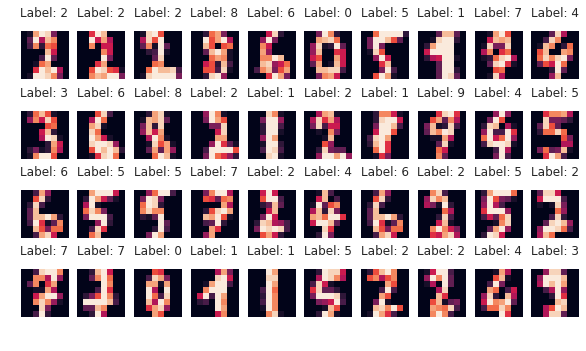

In [5]:
collage_size = 40
rand_ind = np.random.randint(0, 1797, size=collage_size)
plot_digit_subplots(d.images[rand_ind], d.target[rand_ind])

### Pytorch Linear Regression

#### Logistic Regression class

In [6]:
class LogRegression(nn.Module):
    def __init__(self, features_num, classes_num, fit_intercept=True):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(features_num, classes_num, bias=fit_intercept)
    
    def forward(self, x):
        # just make weights * x + bias
        return self.linear(x)

#### Train

In [7]:
def train_torch_log_regression(X, y, model, lr, epochs, X_val=None, y_val=None, verbose=True):
    # set SGD optimizer with model weights and learning rate 
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    losses, losses_val = [], []
    accuracy, accuracy_val = [], []
    cross_entropy = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        # print(epoch)
        optimizer.zero_grad()  # backward() function accumulates gradients
        
        # forward pass
        probs = model(X)
        probs_val = model(X_val) if X_val is not None else None
        
        # backward pass 
        loss_var = cross_entropy(probs, y)
        loss_var_val = cross_entropy(probs_val, y_val) if X_val is not None else None
        loss_var.backward()  # grads
        optimizer.step()
        
        # losses save
        losses.append(loss_var.item())
        losses_val.append(loss_var_val.item()) if X_val is not None else None
        
        # accuracy save
        accuracy.append(accuracy_from_probs(probs, y))
        accuracy_val.append(accuracy_from_probs(probs_val, y_val))
        if verbose and epoch % 10 == 0:
            epoch_val_loss = loss_var_val.item() if X_val is not None else None
            print("Epoch {:4d} | Train Loss: {:10.3f} | Val Loss: {:10.3f}".
                  format(epoch, loss_var.item(), epoch_val_loss))
    return losses, losses_val, accuracy, accuracy_val

def accuracy_from_probs(predicted_probs, y_true):
    y_predicted = predicted_probs.argmax(dim=1)
    accuracy = accuracy_score(y_true, y_predicted)
    return accuracy

#### Train on digits data set

In [8]:
X = torch.tensor(data=d.data, dtype=torch.float32)
y = torch.tensor(data=d.target, dtype=torch.long)

print("X.shape: {} \ny.shape: {}".format(X.shape, y.shape))

X.shape: torch.Size([1797, 64]) 
y.shape: torch.Size([1797])


In [9]:
# split train / validation
tr_ind, val_ind = train_test_split(np.arange(len(y)), train_size=.8, test_size=.2)
print("train size: {}\nvalidation size: {}".format(len(tr_ind), len(val_ind)))
X_tr, X_val = X[tr_ind], X[val_ind]
y_tr, y_val = y[tr_ind], y[val_ind]

train size: 1437
validation size: 360


In [10]:
lr = .1
epochs = 300

model = LogRegression(features_num=X.shape[1], classes_num=10)
losses, losses_val, acc, acc_val = train_torch_log_regression(X, y, model, lr, epochs, X_val, y_val)

Epoch    0 | Train Loss:      6.719 | Val Loss:      6.531
Epoch   10 | Train Loss:     47.307 | Val Loss:     43.148
Epoch   20 | Train Loss:      5.330 | Val Loss:      7.331
Epoch   30 | Train Loss:      3.761 | Val Loss:      4.494
Epoch   40 | Train Loss:      2.474 | Val Loss:      3.027
Epoch   50 | Train Loss:      1.482 | Val Loss:      1.945
Epoch   60 | Train Loss:      1.080 | Val Loss:      1.601
Epoch   70 | Train Loss:      0.898 | Val Loss:      1.493
Epoch   80 | Train Loss:      0.739 | Val Loss:      1.222
Epoch   90 | Train Loss:      0.620 | Val Loss:      1.012
Epoch  100 | Train Loss:      0.525 | Val Loss:      0.834
Epoch  110 | Train Loss:      0.448 | Val Loss:      0.697
Epoch  120 | Train Loss:      0.381 | Val Loss:      0.580
Epoch  130 | Train Loss:      0.324 | Val Loss:      0.477
Epoch  140 | Train Loss:      0.278 | Val Loss:      0.397
Epoch  150 | Train Loss:      0.240 | Val Loss:      0.341
Epoch  160 | Train Loss:      0.211 | Val Loss:      0.2

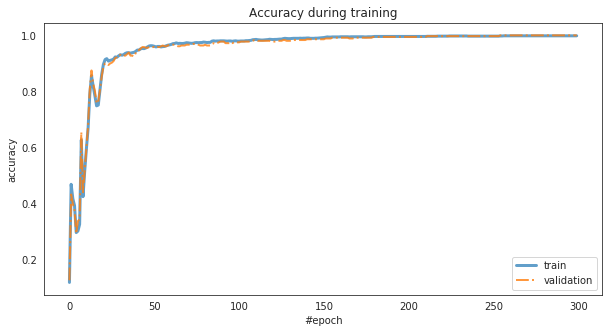

In [11]:
plt.plot(acc, lw=3, alpha=.7, label="train")
plt.plot(acc_val, lw=2, alpha=.8, ls="-.", label="validation")
plt.title("Accuracy during training")
plt.legend()
plt.xlabel("#epoch")
plt.ylabel("accuracy")
fig = plt.gcf()
fig.set_size_inches((10, 5))
plt.show()

#### Evaluate digits

In [12]:
probs = model(X)
predictions = probs.argmax(dim=1)

In [13]:
confusion_matrix(d.target, predictions)

array([[178,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 182,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 177,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 183,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 181,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 179,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0, 173,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 179]])

In [14]:
accuracy_score(d.target, predictions)

0.998330550918197

#### Misclassified examples

In [15]:
# let's see misclassified examples
predictions_np = predictions.numpy()
misclass_ind = np.argwhere(predictions_np != d.target)
misclass_ind = misclass_ind.flatten()
misclass_ind

array([   5, 1553, 1658])

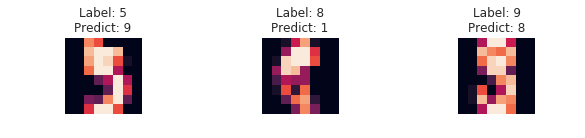

In [16]:
plot_digit_subplots(d.images[misclass_ind], d.target[misclass_ind], predictions_np[misclass_ind])

### Logistic Regression with `sklearn`

In [17]:
model_sk = LogisticRegression(C=1)
model_sk.fit(d.data, d.target)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
pred_sk = model_sk.predict(d.data)
acc_sk = accuracy_score(d.target, pred_sk)

In [19]:
print(acc_sk)

0.993322203672788
